# Decision Stump - Boosting
The Boosting algorithm itself can strictly speaking neither learn nor predict anything since it is build kind of on top of some other (weak) algorithm. The Boosting algorithm is called a "meta algorithm". The Boosting approach can (as well as the bootstrapping approach), be applied, in principle, to any classification or regression algorithm but it turned out that tree models are especially suited. The accuracy of boosted trees turned out to be equivalent to Random Forests with respect and even often outperforms the latter (see for instance Caruana and Niculescu-Mizil (2008)(*An Empirical Comparison of Supervised Learning Algorithms*)). Hastie et al. (2009) call boosted decision trees the "best off-the-shelf classifier of the world" (Hastie et al. 2006 p.340). The mystic behind Boosting is in principal the same as for Random Forest models *-A bunch of weak learners which performs just slightly better than random guessing can be combined to make better predictions than one strong learner-*. Though, the process how these weak learners are created differs.
Recapitulate, that during the creation of our Random Forest model we used the concept of Bagging. During Bagging we have grown a number of *M* trees where each was build on a random sample (allowing resampling) of the original dataset where the random sample had the same length as the original dataset but comprises only a randomly drawn subset of the total feature space. After we have created theses models, we let them make a majority vote to make our final decision. The quintessence is that each tree model is created independent from the outcomes of the other tree models. That is, the "shape" of the tree model is only influenced by the "shape" of the underlying data which in turn is only influenced by chance (*sampling with resampling*). The main difference in the creation of bagged trees using bootstrap aggregation and boosted trees using boosting is that we now replace the (random) resampling by some kind of *weighting* where we allocate the instances with weights and the weights of the ** tree depends on the results returned by the previously created () tree model. Hence, different from the Random Forest approach where we created an ensemble of tree models in parallel, we now create the ensemble in sequence, where the set up of the actual tree is influenced by the outputs of all the previous tree models by altering the weights of the dataset, the tree model is build on. The point is, that by implementing these weights, we introduce some kind of learning where the creation of the ** tree in the boosted model partly depends on the predictions the ** model has made. Therewith, we replace the more or less "randomly-guided" creation of the single datasets during bootstrapping by a "guided" creation. The most prominent boosting algorithm is called *AdaBoost* (adaptive boosting) and was developed by Freund and Schapire (1996). The following discussion is based on the AdaBoost Boosting algorithm. The following illustration gives a visual insight into the boosting algorithm.

Lets first of all create a decision stump and measure the accuracy of this decision stump to get a feeling about the prediction "goodness" or rather "badness" of this model.

Initialize all weights to $w = \frac{1}{n}$ where  is the number of instances in the dataset

- while $t < T$ (T==number of models to be grown) do:
- Create a model and get the hypothesis $h_t(x_n)$ for all datapoints $x_n$ in the dataset
- Calculate the error $\epsilon$ of the training set summing over all datapoints $x_n$ in the training set where $I(cond)$ returns 1 if $I(cond)$ == True and 0 otherwise:

$$ \epsilon_t \ \ = \ \ \ \frac{\sum_{n=1}^{N}w_n^{(t)}*I(y_n\neq h_t(x_n))}{\sum_{n=1}^{N}w_{n}^{(t)}} $$

- Compute $\alpha$ with:

$$\alpha_t\ \ =\ \ \log(\frac{1-\epsilon_t}{\epsilon_t})$$

- Update the weights for the $N$ training instances in the next $(t+1)$ model with:

$$w_{n}^{(t+1)}\ \ = \ \ w_{n}^{(t)}*exp(\alpha_t*I(y_n\neq h_t(x_n)))$$

- After the $T$ iterations, calculate the final output with:

$$f(x)\ \ = \ \ sign(\sum_t^T \alpha_t*h_t(x))$$

In [7]:
"""
Create a Decision Stump
"""

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import style
style.use('fivethirtyeight')
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate
import scipy.stats as sps


# Load in the data and define the column labels

link = 'https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data'
dataset_base = pd.read_csv(link,header=None)
dataset = pd.read_csv(link,header=None)
dataset = dataset.sample(frac=1)
dataset.columns = ['target','cap-shape','cap-surface','cap-color','bruises','odor','gill-attachment','gill-spacing',
             'gill-size','gill-color','stalk-shape','stalk-root','stalk-surface-above-ring','stalk-surface-below-ring','stalk-color-above-ring',
             'stalk-color-below-ring','veil-type','veil-color','ring-number','ring-type','spore-print-color','population',
             'habitat']



# Encode the feature values from strings to integers since the sklearn DecisionTreeClassifier only takes numerical values
for label in dataset.columns:
    dataset[label] = LabelEncoder().fit(dataset[label]).transform(dataset[label])

    
    
Tree_model = DecisionTreeClassifier(criterion="entropy",max_depth=1)


X = dataset.drop('target',axis=1)
Y = dataset['target'].where(dataset['target']==1,-1)



predictions = np.mean(cross_validate(Tree_model,X,Y,cv=100)['test_score'])


print('The accuracy is: ',predictions*100,'%')

The accuracy is:  73.06594399277326 %


Mind that we have trained and tested the model on the same dataset (the whole dataset) using 100-fold Cross Validation. We get an accuracy of  73% which is not good but also not that terribly bad considering that we have used a decision stump for classification (split the dataset only once).

Next, lets see how we can improve this result using a boosted decision stump approach. One thing which might be a bit confusing is that on our way to the final *boosted decision stump*, we use the whole dataset as training and testing dataset (we don't do a train test split). You might remember that we normally want to have a training set, on which we train the model and a testing set on which we test a model - Nevertheless, for Boosting we make an exception and use the whole dataset for training and testing - Just keep this exception in mind-.

With a number of  50 base models we receive an accuracy of  98.67060561299851 %


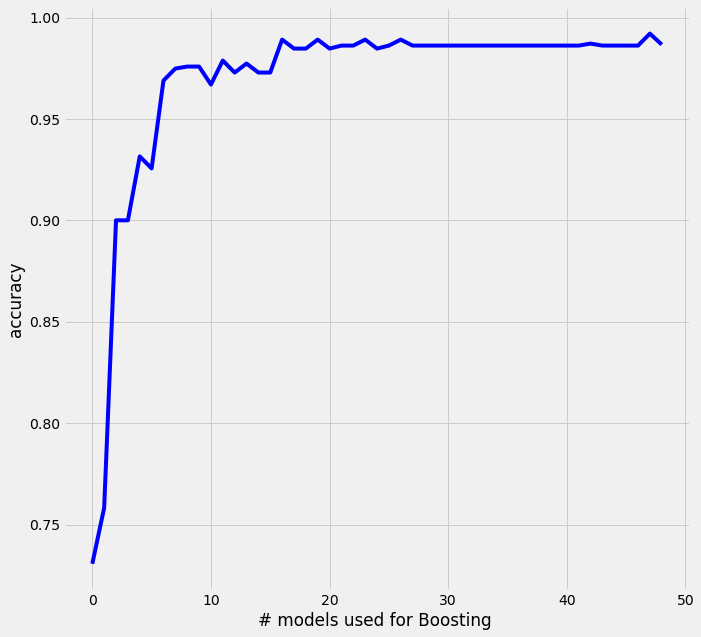

In [2]:
class Boosting:

    def __init__(self,dataset,T,test_dataset):
        self.dataset = dataset
        self.T = T
        self.test_dataset = test_dataset
        self.alphas = None
        self.models = None
        self.accuracy = []
        self.predictions = None
    
    def fit(self):
        # Set the descriptive features and the target feature
        X = self.dataset.drop(['target'],axis=1)
        Y = self.dataset['target'].where(self.dataset['target']==1,-1)

        # Initialize the weights of each sample with wi = 1/N and create a dataframe in which the evaluation is computed
        Evaluation = pd.DataFrame(Y.copy())
        Evaluation['weights'] = 1/len(self.dataset) # Set the initial weights w = 1/N
        

        # Run the boosting algorithm by creating T "weighted models"
        
        alphas = [] 
        models = []
        
        for t in range(self.T):

            # Train the Decision Stump(s)
            Tree_model = DecisionTreeClassifier(criterion="entropy",max_depth=1) # Mind the deth one --> Decision Stump
            
            # We know that we must train our decision stumps on weighted datasets where the weights depend on the results of
            # the previous decision stumps. To accomplish that, we use the 'weights' column of the above created 
            # 'evaluation dataframe' together with the sample_weight parameter of the fit method.
            # The documentation for the sample_weights parameter sais: "[...] If None, then samples are equally weighted."
            # Consequently, if NOT None, then the samples are NOT equally weighted and therewith we create a WEIGHTED dataset 
            # which is exactly what we want to have.
            model = Tree_model.fit(X,Y,sample_weight=np.array(Evaluation['weights'])) 
            
            # Append the single weak classifiers to a list which is later on used to make the 
            # weighted decision
            models.append(model)
            predictions = model.predict(X)
            score = model.score(X,Y)

            # Add values to the Evaluation DataFrame
            Evaluation['predictions'] = predictions
            Evaluation['evaluation'] = np.where(Evaluation['predictions'] == Evaluation['target'],1,0)
            Evaluation['misclassified'] = np.where(Evaluation['predictions'] != Evaluation['target'],1,0)

            # Calculate the misclassification rate and accuracy
            accuracy = sum(Evaluation['evaluation'])/len(Evaluation['evaluation'])
            misclassification = sum(Evaluation['misclassified'])/len(Evaluation['misclassified'])


            # Caclulate the error
            err = np.sum(Evaluation['weights']*Evaluation['misclassified'])/np.sum(Evaluation['weights'])
 
   
            # Calculate the alpha values
            alpha = np.log((1-err)/err)
            alphas.append(alpha)


            # Update the weights wi --> These updated weights are used in the sample_weight parameter
            # for the training of the next decision stump. 
            Evaluation['weights'] *= np.exp(alpha*Evaluation['misclassified'])

            #print('The Accuracy of the {0}. model is : '.format(t+1),accuracy*100,'%')
            #print('The missclassification rate is: ',misclassification*100,'%')
        
        self.alphas = alphas
        self.models = models
            
    def predict(self):
        X_test = self.test_dataset.drop(['target'],axis=1).reindex(range(len(self.test_dataset)))
        Y_test = self.test_dataset['target'].reindex(range(len(self.test_dataset))).where(self.dataset['target']==1,-1)
    
        # With each model in the self.model list, make a prediction 
        
        accuracy = []
        predictions = []
        
        for alpha,model in zip(self.alphas,self.models):
            prediction = alpha*model.predict(X_test) # We use the predict method for the single decisiontreeclassifier models in the list
            predictions.append(prediction)
            self.accuracy.append(np.sum(np.sign(np.sum(np.array(predictions),axis=0))==Y_test.values)/len(predictions[0]))
            # The above line of code could be a little bit confusing and hence I will do up the single steps:
            # Goal: Create a list of accuracies which can be used to plot the accuracy against the number of base learners used for the model
            # 1. np.array(predictions) --> This is the array which contains the predictions of the single models. It has the shape 8124xn
            # and hence looks like [[0.998,0.87,...0.87...],[...],[...],[0.99,1.23,...,1.05,0,99...]] 
            # 2. np.sum(np.array(predictions),axis=0) --> Summs up the first elements of the lists, that is 0,998+...+...+0.99. This is 
            # done since the formula for the prediction wants us to sum up the predictions of all models for each instance in the dataset. 
            # Hence if we have for example 3 models than the predictions array has the shape 8124x3 (Imagine a table with 3 columns and
            # 8124 rows). Here the first column containst the predictions for the first model, the second column contains the 
            # prediction for the second model, the third column the prediction for the third model (mind that the
            # second and third model are influenced by the results of the first resoectvely the first and the
            # second model). This is logical since the results from column (model)
            # n-1 are used to alter the weights of the nth model and the results of the nth model are then used to alter the weights
            # of the n+1 model. 
            # 3. np.sign(np.sum(np.array(predictions),axis=0)) --> Since our test target data are elements of {-1,1} and we want to 
            # have our prediction in the same format, we use the sign function. Hence each column in the accuracy array is like
            # [-0.998,1.002,1.24,...,-0.89] and each element represents the combined and weighted prediction of all models up this column
            # (so if we are for instance in the 5th column and for the 4th instnace we find the value -0.989, this value represents the 
            # weighted prediction of a boosted model with 5 base learners for the 4th instance. The 4th instance of the 6th column represents
            # the weighted and combined predictions of a boosted model with 6 base learners while the 4th instance of the 4th column represents
            # the predction of a model with 4 base learners and so on and so forth...). To make a long story short, we are interested in the 
            # the sign of these comined predictions. If the sign is positive, we know that the true prediction is more likely postive (1) then
            # negaive (-1). The higher the value (postive or negative) the more likely it is that the model returns the correct prediction.
            # 4. np.sum(np.sign(np.sum(np.array(predictions),axis=0))==Y_test.values)/len(predictions[0]) --> With the last step we have transformed the array 
            # into the shape 8124x1 where the instances are elements {-1,1} and therewith we are now in the situation to compare this 
            # prediction with our target feature values. The target feature array is of the shape 8124x1 since for each row it contains
            # exactly one prediction {-1,1} just as our just created array above --> Ready to compare ;).
            # The comparison is done with the == Y_test.values command. As result we get an 
            # array of the shape 8124x1 where the instances are elements of {True,False} (True if our prediction is consistent with the 
            # target feature value and False if not). Since we want to calculate a percentage value we have to calculate the fraction of 
            # instances which have been classified correctly. Therefore we simply sum up the above comparison array 
            # with the elements {True,False} along the axis 0.
            # and divide it by the total number of rows (8124) since True is the same as 1 and False is the same as 0. Hence correct predictions 
            # increase the sum while false predictions does not change the sum. If we predicted nothing correct the calculation is 0/8124 and 
            # therewith 0 and if we predicted everything correct, the calculation is 8124/8124 and thereiwth 1. 
            # 5. self.accuracy.append(np.sum(np.sign(np.sum(np.array(predictions),axis=0))==Y_test.values)/len(predictions[0])) -->
            # After we have computed the above steps, we add the result to the self.accuracy list. This list has the shape n x 1, that is,
            # for a model with 5 base learners this list has 5 entries where the 5th entry represents the accuracy of the model when all
            # 5 base learners are combined, the 4th element the accuracy of the model when 4 base learners are combined and so on and so forth. This 
            # procedure has been explained above. That's it and we can plot the accuracy.
        self.predictions = np.sign(np.sum(np.array(predictions),axis=0))

   
        

        


######Plot the accuracy of the model against the number of stump-models used##########

number_of_base_learners = 50

fig = plt.figure(figsize=(10,10))
ax0 = fig.add_subplot(111)


for i in range(number_of_base_learners):
    model = Boosting(dataset,i,dataset)
    model.fit()
    model.predict()

ax0.plot(range(len(model.accuracy)),model.accuracy,'-b')
ax0.set_xlabel('# models used for Boosting ')
ax0.set_ylabel('accuracy')
print('With a number of ',number_of_base_learners,'base models we receive an accuracy of ',model.accuracy[-1]*100,'%')    
                 
plt.show()        

As we can see, the predictive power of these boosted decision stumps is really amazing. For more than 8000 testing instances we got all correct and therewith an accuracy of 100% with a model which contains 400 base learners. Also interesting is the fact, that the accuracy increases rapidly up to  10 base learners and with  70 base learners our model returns an accuracy of close to 100%.
Nevertheless, allow me a side node. First, this kind of boosted model is kind of computationally expensive, that is, its predictive power comes with the costs of computational expensiveness and therewith we have to make a compromise between accuracy and computation effort. Taking the above example we need  400 base learners to get an accuracy of 100% but with  70 decision stumps we already get close to 100%. So we have to decide how important the 100% mark is. Second, the above shown model does not claim to be computationally efficient at all. The model should show how a boosted decision stump can be created from scratch without taking care of computational efficiency. Hence, there are for sure ways how the above code can be made more efficient and therewith the model more fast. It is up to you, playing around with the code and check if you can, for instance, implement some vectorized calculations instead of the loops or something like that.

# Boosting with sklearn

As always, we will now use the prepackaged sklearn AdaBoostClassifier with the parameters set to the same values we used above. The documentation says:
"An AdaBoost [Y. Freund, R. Schapire, “A Decision-Theoretic Generalization of on-Line Learning and an Application to Boosting”, 1995] classifier is a meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases."[1]
The parameters we have to adjust are:

- base_estimator: We set this to the default value which is DecisionTreeClassifier as we have used above. Mind that we could also define a variable like estimator= DecisionTreeClassifier and parametrize this estimator by setting max_depth = 1, criterion = "entropy",... But for convenience we will omit this here
- n_estimators: This is the number of base learners which should be used. We set this to 400 as above.
- learning_rate: The default value is 1.0 and reduces the contribution of each tree by the learning rate.We set this to the default value since we don't have explicitly incorporated a learning rate.

The rest of the parameter is set to the default values.

In [3]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier


for label in dataset.columns:
    dataset[label] = LabelEncoder().fit(dataset[label]).transform(dataset[label])
    
X = dataset.drop(['target'],axis=1)
Y = dataset['target']

#model = DecisionTreeClassifier(criterion='entropy',max_depth=1)
#AdaBoost = AdaBoostClassifier(base_estimator= model,n_estimators=400,learning_rate=1)

AdaBoost = AdaBoostClassifier(n_estimators=400,learning_rate=1,algorithm='SAMME')

AdaBoost.fit(X,Y)

prediction = AdaBoost.score(X,Y)

print('The accuracy is: ',prediction*100,'%')

The accuracy is:  100.0 %


In [8]:
dataset_base

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,e,k,s,n,f,n,a,c,b,y,...,s,o,o,p,o,o,p,b,c,l
8120,e,x,s,n,f,n,a,c,b,y,...,s,o,o,p,n,o,p,b,v,l
8121,e,f,s,n,f,n,a,c,b,n,...,s,o,o,p,o,o,p,b,c,l
8122,p,k,y,n,f,y,f,c,n,b,...,k,w,w,p,w,o,e,w,v,l


In [9]:
dataset

,target,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
5043,1,5,3,9,0,2,1,0,0,2,...,1,0,6,0,2,1,2,1,4,4
3122,1,5,0,3,0,2,1,0,0,7,...,1,4,0,0,2,1,2,1,5,0
2953,0,2,0,4,1,5,1,0,0,5,...,2,3,6,0,2,1,4,3,5,0
6969,1,3,3,2,0,2,1,0,1,0,...,1,6,7,0,2,1,0,7,4,0
6586,1,3,3,4,0,8,1,0,1,0,...,1,7,6,0,2,1,0,7,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3230,0,2,3,3,1,5,1,0,0,5,...,2,7,3,0,2,1,4,3,4,0
4194,1,2,2,0,1,2,1,0,0,10,...,0,7,7,0,2,1,4,1,3,5
2107,0,5,3,2,1,5,1,0,0,9,...,2,6,6,0,2,1,4,2,5,0
3976,1,2,0,3,0,2,1,0,0,7,...,1,4,4,0,2,1,2,1,4,1
